## Necessary Imports

In [2]:
# Necessary imports
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D, Input
from keras.utils import np_utils
import pickle
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Data Reading and Preprocessing

In [3]:
# Function to preprocess every image before feeding to the model
def preprocess_image(image):
    try:
        image = img_to_array(image)
        image = preprocess_input(image)
        return image
    except Exception as e:
        print("Exception:", e)

In [4]:
# Identify different disease categories
DATASET_DIRECTORY = "../datasets/plant_diseases_dataset/"
data_set = DATASET_DIRECTORY+"train/"
test_set = DATASET_DIRECTORY+"test/"
categories = os.listdir(data_set)
categories

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spid

In [5]:
# Pre-processing and preparing the training and validation data
data = []
label = []
test_data = []
test_label = []

for category in categories:
    data_path = os.path.join(data_set, category)
    for image in os.listdir(data_path):
        image_path = os.path.join(data_path, image)
        image = load_img(image_path, target_size=(224, 224))
        data.append(preprocess_image(image))
        label.append(category)

for image in os.listdir(test_set):
    image_path = os.path.join(test_set, image)
    image = load_img(image_path, target_size=(224, 224))
    test_data.append(preprocess_image(image))

In [6]:
data = np.array(data, dtype="float32")
# Encoding the label data
encoder = LabelEncoder()
label = encoder.fit_transform(label)
# Transforming to array of categorical data
label = np_utils.to_categorical(label)
# Storing the mapping data
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
with open('../models/plant_disease_mappings_data.p', 'wb') as fp:
    pickle.dump(le_name_mapping, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# Performing train test split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 100)

## Model Building

In [8]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
for layer in base_model.layers:
    layer.trainable = False

main_model = Sequential([base_model,
                AveragePooling2D(pool_size=(7, 7)),
                Flatten(),
                Dense(128, activation="relu"),
                Dropout(0.5),
                Dense(38, activation="softmax")])

In [9]:
# Model compilation
main_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [10]:
# Model training and validation
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
hist = main_model.fit(X_train, y_train, epochs=20, callbacks=[checkpoint], validation_split=0.2)

Epoch 1/20
76/76 [==============================] - 124s 1s/step - loss: 3.3906 - accuracy: 0.1439 - val_loss: 1.8135 - val_accuracy: 0.6299
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/20
76/76 [==============================] - 108s 1s/step - loss: 1.8273 - accuracy: 0.5038 - val_loss: 1.0421 - val_accuracy: 0.7812
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/20
76/76 [==============================] - 98s 1s/step - loss: 1.2561 - accuracy: 0.6415 - val_loss: 0.7293 - val_accuracy: 0.8289
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/20
76/76 [==============================] - 97s 1s/step - loss: 0.9718 - accuracy: 0.7282 - val_loss: 0.6177 - val_accuracy: 0.8668
INFO:tensorflow:Assets written to: model-004.model\assets
Epoch 5/20
76/76 [==============================] - 96s 1s/step - loss: 0.7413 - accuracy: 0.7763 - val_loss: 0.5392 - val_accuracy: 0.8618
INFO:tensorflow:Assets written to: model-005.model\assets
Epoch 6/

In [19]:
# Model testing and Evaluation
y_pred_idx = main_model.predict(X_test)
y_pred = np.argmax(y_pred_idx, axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        17
           2       1.00      0.94      0.97        17
           3       0.96      1.00      0.98        24
           4       0.95      0.95      0.95        20
           5       1.00      0.96      0.98        23
           6       1.00      0.95      0.98        21
           7       0.86      0.76      0.81        25
           8       0.94      1.00      0.97        15
           9       0.78      0.88      0.82        24
          10       1.00      1.00      1.00        26
          11       0.83      0.88      0.86        17
          12       0.93      0.89      0.91        28
          13       1.00      1.00      1.00        17
          14       0.95      1.00      0.97        18
          15       0.82      1.00      0.90        14
          16       1.00      0.95      0.98        21
          17       1.00    

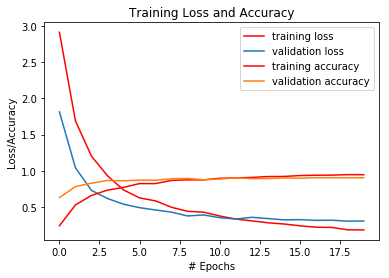

In [20]:
plt.figure()
plt.plot(hist.history['loss'], 'r', label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.plot(hist.history['accuracy'], 'r', label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('# Epochs')
plt.ylabel('Loss/Accuracy')
plt.title("Training Loss and Accuracy")
plt.legend()
plt.show()